In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [31]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm
from glob import glob
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
import xml.etree.ElementTree as xet
from keras.models import load_model, Sequential
from sklearn.model_selection import train_test_split

In [32]:
def load_images(directory):
    images = []

    for filepath in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory,filepath)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        img = cv2.medianBlur(img,5)
        images.append(img)
    
    images = np.array(images).reshape(len(images),224,224,3)
    return images

In [33]:
path = glob("../input/car-plate-detection/annotations/*.xml")
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

for filename in path:
    data = xet.parse(filename)
    root = data.getroot()
    obj = root.find('object')
    labels_info = obj.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [34]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/car-plate-detection/annotations/Cars3...,209,283,135,169
1,../input/car-plate-detection/annotations/Cars1...,191,242,147,169
2,../input/car-plate-detection/annotations/Cars7...,115,277,115,153
3,../input/car-plate-detection/annotations/Cars1...,36,62,175,186
4,../input/car-plate-detection/annotations/Cars2...,71,215,205,246


In [35]:
df.shape

(433, 5)

In [36]:
images = load_images('../input/car-plate-detection/images')

  0%|          | 0/433 [00:00<?, ?it/s]

In [37]:
images.shape

(433, 224, 224, 3)

In [38]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../input/car-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'../input/car-plate-detection/images/Cars339.png'

In [39]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]

['../input/car-plate-detection/images/Cars339.png',
 '../input/car-plate-detection/images/Cars13.png',
 '../input/car-plate-detection/images/Cars74.png',
 '../input/car-plate-detection/images/Cars16.png',
 '../input/car-plate-detection/images/Cars291.png',
 '../input/car-plate-detection/images/Cars236.png',
 '../input/car-plate-detection/images/Cars429.png',
 '../input/car-plate-detection/images/Cars132.png',
 '../input/car-plate-detection/images/Cars251.png',
 '../input/car-plate-detection/images/Cars51.png']

In [40]:
bbox_coords = df.iloc[:,1:].values
labels = []

for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    xmin,xmax,ymin,ymax = bbox_coords[ind]
    nxmin, nxmax = int(xmin/(w/255.)), int(xmax/(w/255.))
    nymin, nymax = int(ymin/(h/255.)), int(ymax/(h/255.))
    labels.append((nxmin,nxmax,nymin,nymax))

In [41]:
labels = np.array(labels)
labels

array([[106, 144, 114, 143],
       [121, 154, 139, 160],
       [ 73, 176, 109, 146],
       ...,
       [144, 208, 153, 178],
       [100, 157, 163, 186],
       [ 24,  93, 214, 237]])

In [42]:
X = np.array(images,dtype=np.float32)
y = np.array(labels,dtype=np.float32)

In [43]:
X = X / 255.
y = y / 255.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42)

In [45]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
Non-trainable params: 14,714,688
__________________________________

In [46]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [47]:
r = model.fit(X_train,
              y_train,
              epochs=50,
              batch_size=32,
              validation_data=(X_val,y_val),
              verbose=1)

Epoch 1/50
10/10 [==============================] - 89s 9s/step - loss: 0.0711 - accuracy: 0.5531 - val_loss: 0.0520 - val_accuracy: 0.5429
Epoch 2/50
10/10 [==============================] - 87s 9s/step - loss: 0.0383 - accuracy: 0.5498 - val_loss: 0.0232 - val_accuracy: 0.4000
Epoch 3/50
10/10 [==============================] - 87s 9s/step - loss: 0.0261 - accuracy: 0.5563 - val_loss: 0.0271 - val_accuracy: 0.5429
Epoch 4/50
10/10 [==============================] - 87s 9s/step - loss: 0.0222 - accuracy: 0.5884 - val_loss: 0.0241 - val_accuracy: 0.6286
Epoch 5/50
10/10 [==============================] - 88s 9s/step - loss: 0.0191 - accuracy: 0.6527 - val_loss: 0.0245 - val_accuracy: 0.6286
Epoch 6/50
10/10 [==============================] - 86s 9s/step - loss: 0.0158 - accuracy: 0.7138 - val_loss: 0.0264 - val_accuracy: 0.6000
Epoch 7/50
10/10 [==============================] - 87s 9s/step - loss: 0.0132 - accuracy: 0.7428 - val_loss: 0.0274 - val_accuracy: 0.5143
Epoch 8/50
10/10 [==

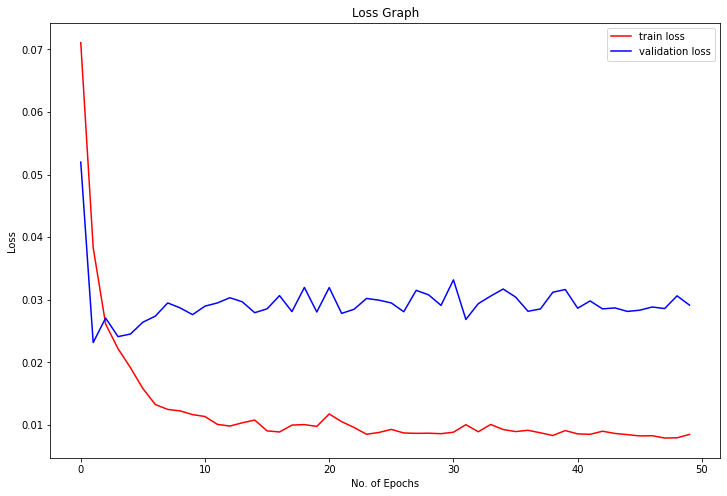

In [52]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

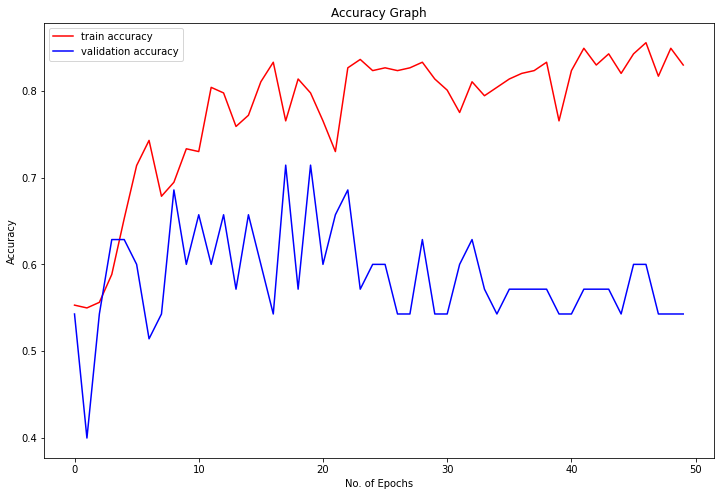

In [53]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [50]:
loss, acc = model.evaluate(X_test,y_test)
print("Test Loss:",loss)
print("Test Accuracy:",acc)

3/3 [==============================] - 21s 7s/step - loss: 0.0480 - accuracy: 0.4483
Test Loss: 0.04796554893255234
Test Accuracy: 0.4482758641242981


In [51]:
model.save('license_plate_detector.h5')
detector = load_model('license_plate_detector.h5')
detector